# Turning point analysis
- TODO: encapsulation and check N=1,2,3, ...
- Work flow
    1. turn tick data into daily data
        - findataflow
    1. For each maturity
        - detect turing points (N)
            - N = 1, 2, 3, ...
        - combine turning points
    1. summarize turning points by day-to-maturity
        - frequency
        - slope
        - duration
        - optimal lambda


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pretty print for consecutive dfs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime

In [4]:
import config as cfg
from findataflow.dataprocs import resample

In [5]:
def get_maturity(series_date):
    settlements = pd.to_datetime(pd.read_csv(cfg.PATH_SETTLEMENTS).settlement).dt.date
    maturities = series_date.where(series_date.isin(settlements)).fillna(method='bfill')
    maturities.where(maturities >= settlements.min(), inplace = True)
    return maturities

In [6]:
def get_daily_TXF_OHLC():
    df_ohlc = resample.get_OHLCV_given_frequency(symbol='TXF', freq='1D')
    df_ohlc.reset_index(inplace=True)
    df_ohlc.rename(columns={'index': 'tx_datetime'}, inplace=True)
    df_ohlc['tx_datetime'] = df_ohlc.tx_datetime.dt.date
    df_ohlc.loc[df_ohlc.shape[0]] = [datetime.date(2014,3,19), 8734, 8742, 8684, 8696, np.nan]#TODO: no data
    df_ohlc.sort_values('tx_datetime', inplace=True)
    df_ohlc['maturity'] = get_maturity(df_ohlc.tx_datetime)
    df_ohlc['day_to_maturity'] = (df_ohlc.tx_datetime - df_ohlc.maturity).dt.days
    return df_ohlc

## turing point at maturity-level
- detect turing points (N)
    - N = 1, 2, 3, ...
- combine turning points

In [7]:
def get_marked_turnpt(prc_ohlc, N): 
    assert 'tx_datetime' in prc_ohlc.columns, 'tx_datetime is not in column name list'
    assert 'low' in prc_ohlc.columns, 'low is not in column name list'
    assert 'high' in prc_ohlc.columns, 'high is not in column name list'
    
    df_prc = prc_ohlc[['tx_datetime']].copy()
    window = prc_ohlc[['close']].rolling(window=2*N+1, center=True, min_periods=(N+1)+1)
    df_prc['N'] = N
    df_prc['is_turnpt_upward'] = (prc_ohlc.close == window.min().close).astype(int)
    df_prc['is_turnpt_downward'] = (prc_ohlc.close == window.max().close).astype(int)
    df_prc['is_turnpt'] = df_prc.is_turnpt_upward + df_prc.is_turnpt_downward * (-1)
    return df_prc

def get_combined_turnpt(df_turnpt_ohlc):
    def get_extreme(df_same):
        direction = df_same.is_turnpt.unique()
        assert len(direction) == 1, 'should be only 1 direction'
        direction = direction[0]
        if direction == 1:
            idx_candidate = df_same.close.values.argmin()
        elif direction == -1:
            idx_candidate = df_same.close.values.argmax()
        df_extreme = df_same.iloc[[idx_candidate]]
        return df_extreme
    
    df = df_turnpt_ohlc.query('is_turnpt != 0').reset_index(drop=True)
    df['same_direction'] = np.where((df.is_turnpt * df.is_turnpt.shift(1)) == -1, 1, 0).cumsum()
    df_turnpt_combined = df.groupby('same_direction', as_index=False).apply(get_extreme).reset_index(drop=True)
    
    if df_turnpt_combined.empty:
        return pd.DataFrame(columns=df_turnpt_ohlc.columns)
    
    common_columns = ['tx_datetime', 'N']
    df_turnpt_combined = df_turnpt_combined[common_columns+['is_turnpt_upward', 'is_turnpt_downward', 'is_turnpt']]
    df_turnpt_ohlc = df_turnpt_ohlc[common_columns + [col for col in df_turnpt_ohlc.columns if col not in df_turnpt_combined.columns]]
    df_turnpt_ohlc_combined = df_turnpt_ohlc.merge(df_turnpt_combined, on=common_columns, how='left')
    return df_turnpt_ohlc_combined

def plot_turnpt(df_turnpt_ohlc, N):
    df_plot = df_turnpt_ohlc.copy()
    df_plot.set_index('tx_datetime', inplace=True)
    def find_loc(df, dates):
        return [df.index.get_loc(date) for date in dates]
    
    dates_upward = df_plot.query(f'(N == {N}) and (is_turnpt_upward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='white', markevery=find_loc(df_plot, dates_upward), marker='^', markerfacecolor='red', markeredgewidth=0.0)

    dates_downward = df_plot.query(f'(N == {N}) and (is_turnpt_downward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='black', markevery=find_loc(df_plot, dates_downward), marker='v', markerfacecolor='green', markeredgewidth=0.0)
    plt.title(f'N: {N}')
    

def get_turnpt_magnitude(df_turnpt, N):
    def get_prc_diff(dt_start, dt_end):
        if dt_end is np.nan:
            return np.nan
        prc_start = df_turnpt[df_turnpt.tx_datetime.isin([dt_start])].close.values[0]
        prc_end = df_turnpt[df_turnpt.tx_datetime.isin([dt_end])].close.values[0]
        prc_diff = prc_end - prc_start
        return prc_diff
    idx_columns = ['tx_datetime', 'maturity']

    df_m = df_turnpt.query(f'(N == {N}) and (is_turnpt != 0)')[idx_columns].copy()
    df_m['next_dt_turnpt'] = df_m.tx_datetime.shift(-1).fillna(df_m.tx_datetime.max())#.fillna(df_m.maturity.max())
    df_m['prc_diff'] = df_m.apply(lambda x: get_prc_diff(x.tx_datetime, x.next_dt_turnpt), axis=1)
    df_m['duration'] = (df_m.next_dt_turnpt - df_m.tx_datetime).dt.days
    df_m['slope'] = df_m.prc_diff.div(df_m.duration)
    df_m = df_turnpt.merge(df_m, on = idx_columns, how= 'left')    
    return df_m

In [8]:
def get_df_turnpt_measures(N):
    df_ohlc = get_daily_TXF_OHLC()
    df_turnpt = (
        df_ohlc.
        groupby('maturity', as_index=False).apply(lambda x: get_marked_turnpt(x, N)).
        merge(df_ohlc, on='tx_datetime', how='left').
        groupby('maturity', as_index=False).apply(get_combined_turnpt).
        groupby('maturity', as_index=False).apply(lambda x: get_turnpt_magnitude(x, N))
    )
    return df_turnpt

def analysis(df):
    df = df.query('turn == 1').copy()
    df_res = pd.DataFrame(index=[0])
    df_res['n_turn'] = df.shape[0]
    df_res['prc_diff'] = df.prc_diff.mean()
    df_res['duration'] = df.duration.mean()
    df_res['slope'] = df.slope.mean()
    return df_res

def plot_measure(df_turnpt_measures):
    assert df_turnpt_measures.N.nunique() == 1, 'df_turnpt should have only 1 N'
    N = df_turnpt_measures.N.iloc[0]
    df_analysis = pd.melt(df_turnpt_measures, id_vars=[col for col in df_turnpt_measures.columns if col not in ['is_turnpt_upward', 'is_turnpt_downward']], var_name = 'direction', value_name='turn')
    idx_columns = ['N', 'direction', 'day_to_maturity']
    df_summary = df_analysis.groupby(idx_columns).apply(analysis).reset_index(idx_columns)
    for col in df_summary.columns:
        if col in idx_columns:
            continue
        df_summary.set_index(['direction', 'day_to_maturity'])[col].unstack('direction').plot.bar(figsize=(15, 5), title=f'{col} at N={N}')
    plt.show()

In [9]:
# # test 
# df_ohlc = get_daily_TXF_OHLC()
# n1_upward = df_ohlc.groupby('maturity', as_index=False).apply(lambda x: get_marked_turnpt(x, 1)).is_turnpt_upward.sum()
# n2_upward = df_ohlc.groupby('maturity', as_index=False).apply(lambda x: get_marked_turnpt(x, 2)).is_turnpt_upward.sum()
# assert n1_upward == 457 and n2_upward == 256

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/pandas/core/groupby/groupby.py:980: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis, keys=keys)


transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV
transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


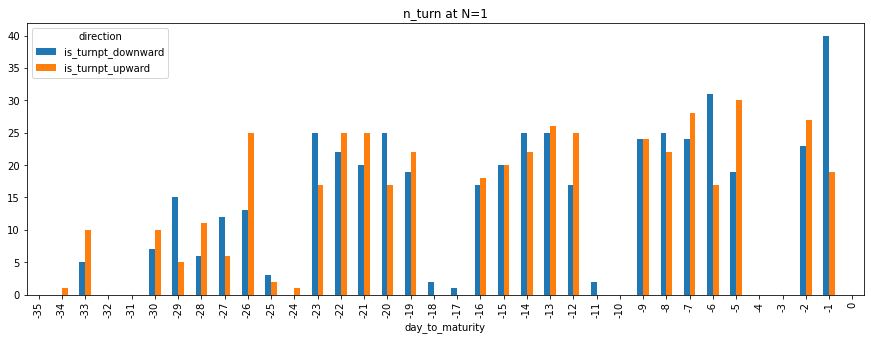

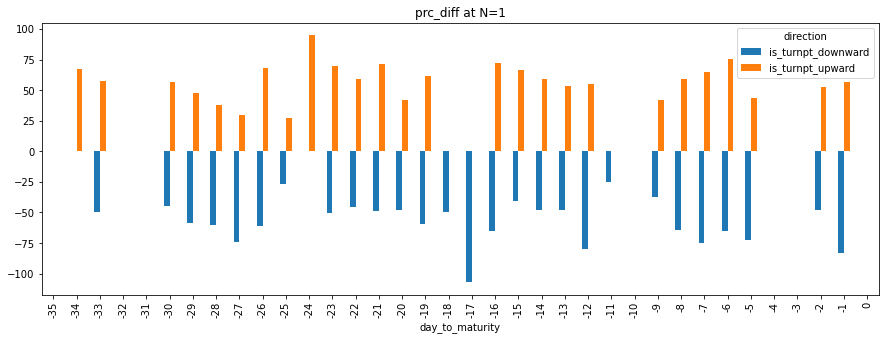

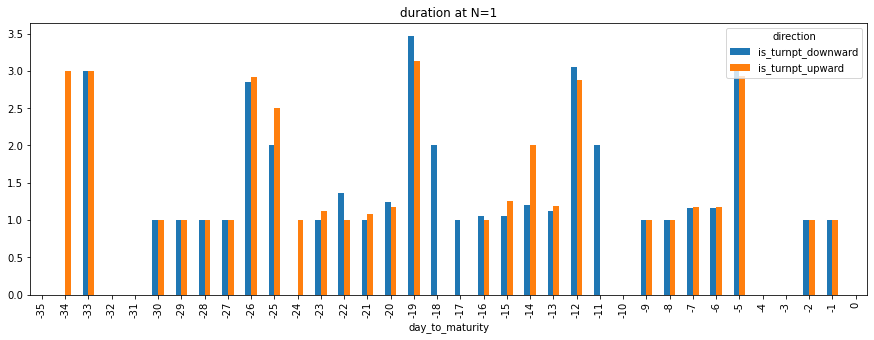

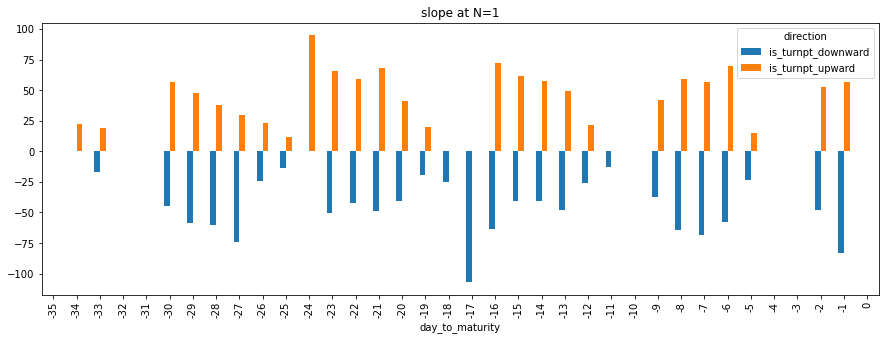

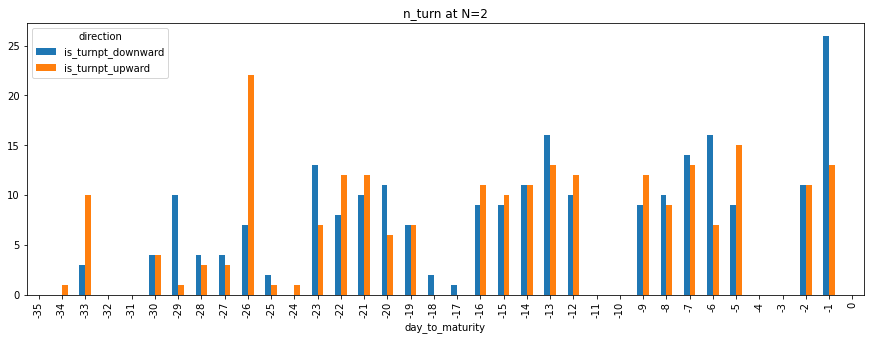

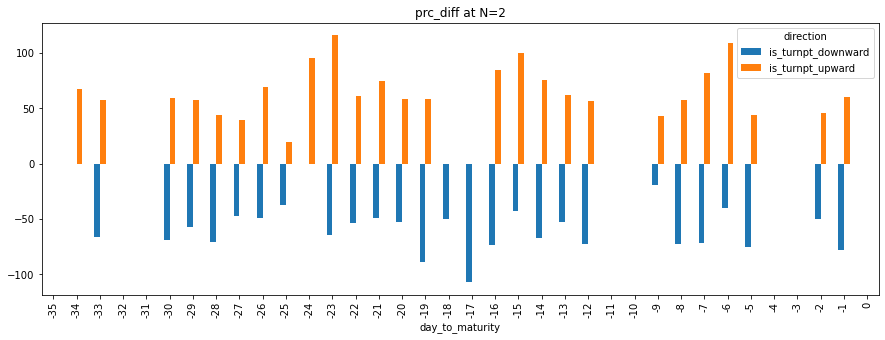

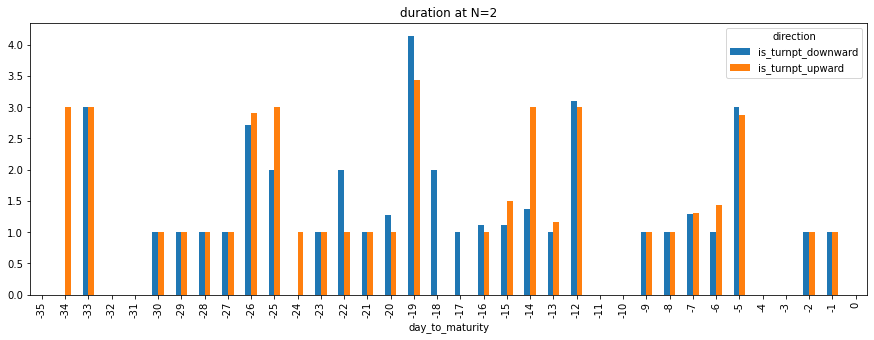

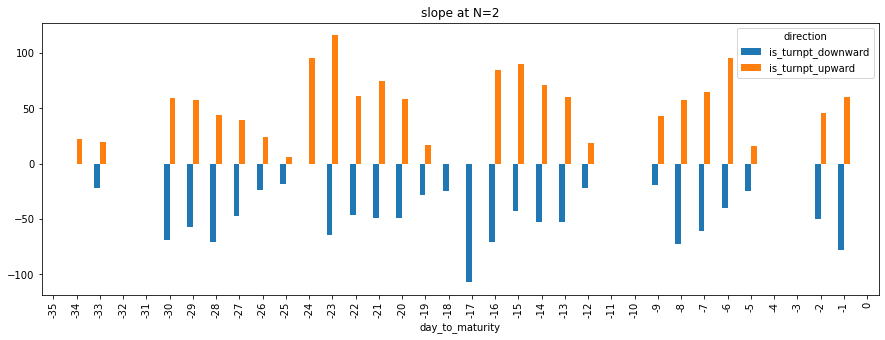

In [10]:
if __name__ == '__main__':
    dfs = {N: get_df_turnpt_measures(N) for N in [1, 2, 3, 5, 10]}
    plot_measure(dfs[1])
    plot_measure(dfs[2])

# which N is the best?
- check trading opportunity